In [34]:
import numpy as np
import scipy.signal
import sounddevice as sd
%matplotlib inline
from pylab import *
import matplotlib.figure
import itertools
import random
import mpld3
from scipy import stats
mpld3.enable_notebook()
rcParams['figure.figsize'] = 10, 6
rcParams['figure.dpi'] = 90

## Transmitting

First, we take text input and convert the file into binary and fit the binary elements into a numpy array. We also add a barker code to the beginning of our signal to tell our receiver the location of the beginning of our message. This sequence of bits signals the beginning of our transmission and is rarely  found in noise. In addition, we added 40 zeros on either side to avoid having the signal be cut off on the receiver's end.

In [8]:
BARKER_CODE = np.array([1,1,1,0,0,0,1,0,0,1,0])

def pad(data, padding):
    data = np.concatenate([padding, data])
    data = np.concatenate([data, padding])
    return data

def file_to_bits(filename):
    with open (filename, "r") as myfile:
        data=myfile.read()
        result = []
        for c in data:
            bits = bin(ord(c))[2:]
            bits = '00000000'[len(bits):] + bits
            result.extend([int(b) for b in bits])
        temp = np.array(result)   
        temp = np.concatenate([BARKER_CODE, temp])
        temp = pad(temp, np.zeros(40))
        return temp

bitstream = file_to_bits('test.txt')

# Modulation

Our implementation essentially relies on quickly shifting between 2 frequencies to send values of "1" and "0". Getting this right was the most time-consuming part of our project, and we wrote two separate modulation implementations: GFSK and FSK. When GFSK seemed to be creating fairly abysmal accuracy rates, we tried FSK and saw noticeable improvements.

# Roadblocks:

First off, our first implementation, GFSK, didn't work, the remnants of which you see below. We looked for alternate solutions and wrote and implementation of FSK that seemed to work a lot better.

In addition, a large factor in our accuracy were tuning the parameters (both here and on the receiving end). Some of the major parameters we considered included the carrier frequency, the frequency deviation, and the sampling rate. We quickly found that achieving a high accuracy on very low bit_rates was easy, but as we increased bit_rate all of our other parameters had to change. We changed the carrier frequency and frequency deviations around, looking at the Fourier Transform plots to identify the best set of parameters. These plots also helped us find the cutoffs for the bandpass filters that we used for demodulation.

In [11]:
def gauss_imp(BT, span, sample_rate):
    #num_coefficients is the sampling rate of the filter
    #3db_bandwidth is the 3db bandwidth of the gaussian filter
    #symbol time is the time difference between two symbols during transmission
    alph = np.sqrt(2. * np.pi / np.log(2)) * BT
    imp = np.linspace(- span * sample_rate / 2, span * sample_rate / 2, span*sample_rate)
    #generate coefficents
    imp *= np.sqrt(np.pi) * alph / sample_rate
    imp = - np.power(imp, 2)
    imp = np.exp(imp)
    imp *= alph
    imp /= sum(imp)
    return imp

def convolve(data, imp):
    out = []
    for a in range(len(data)):
        count = 0
        for i in range(len(imp)):
            if a - i >= 0:
                count += imp[i] * data[a - i]
        out.append(count)
    return np.array(out)

def GFSK_mod(carrier_freq, mod_index, mod_sample_rate, data, bit_rate, BT, span):
    total_time = len(data) / bit_rate
    
    time = np.linspace(0, total_time, total_time * mod_sample_rate)
    
    bit_span = mod_sample_rate/bit_rate
    
    sampled_data = np.repeat(data, bit_span)
    
    imp = gauss_imp(BT, span, bit_span)
    
    filtered_data = scipy.signal.convolve(sampled_data, imp, mode='same')
    
    
    plt.figure()
    plt.plot(filtered_data)
    plt.plot(sampled_data)
    plt.title('Filtered Data')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (V)')
    plt.show()
    
    return time, np.cos(2 * np.pi * carrier_freq * time + mod_index * filtered_data)

def FSK_mod(carrier_freq, freq_dev, mod_sample_rate, data, bit_rate):
    total_time = len(data) / bit_rate
    
    time = np.linspace(0, total_time, total_time * mod_sample_rate)
    
    bit_span = mod_sample_rate/bit_rate
    
    sampled_data = np.repeat(data, bit_span)
    
    return time, np.cos(2 * np.pi * carrier_freq * time + 2 * np.pi * freq_dev * sampled_data * time)

def transmit(signal):
    # signal is an np.array of the signal we are playing
    frames_per_second = 48000
    sd.play(data = signal, samplerate = fs, blocking = False)

Below is a plot of an example of a sound wave that we would have played to transmit some randomly generated data. The random data consists of 8 bits. The sampling rate of the sound wave is at 44.1 kHz. The data rate is 100 bits per second. The carrier wave is 1.8 kHz and the frequency deviation is 600 Hz.

Data: [1, 1, 1, 0, 0, 0, 1, 0]


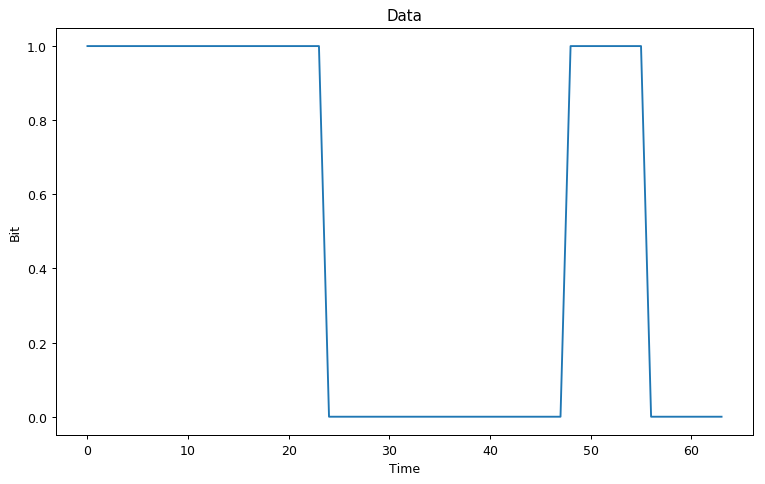

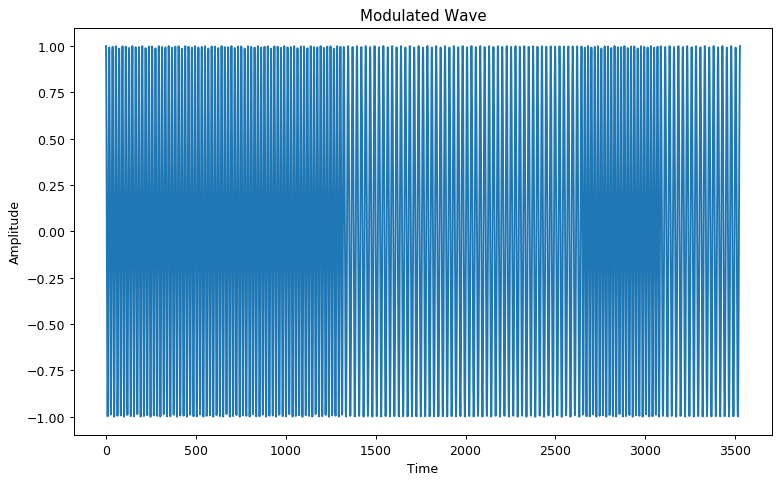

In [22]:
INPUT_SAMPLE_RATE = 44100
random_data = [random.randint(0, 1) for i in range(8)] 
_, test_signal = FSK_mod(1800, 600, INPUT_SAMPLE_RATE, random_data, 100)

print("Data:", random_data)

plt.figure()
plt.plot(np.repeat(random_data, 8))
plt.title('Data')
plt.xlabel('Time')
plt.ylabel('Bit')

plt.figure()
plt.plot(test_signal)
plt.title('Modulated Wave')
plt.xlabel('Time')
plt.ylabel('Amplitude')

In [19]:
sd.play(test_signal, samplerate = INPUT_SAMPLE_RATE, blocking=True)

Below shows a closeup of the transition between one frequency and another in our 

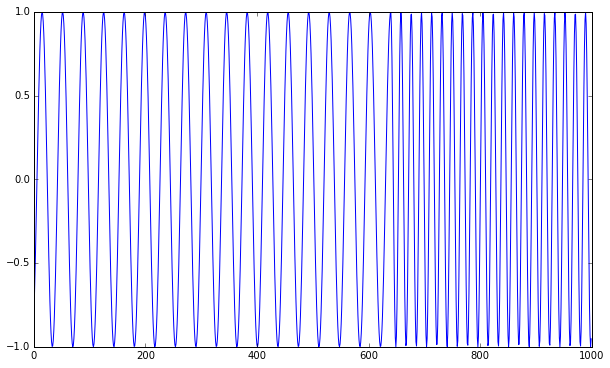

In [114]:
plt.plot(test_signal[17000:18000])